
## EE 342:  Lab 1 - Elementary Music Synthesis


**Overview**
The purpose of this lab is to familiarize you with constructing and processing discrete-time sound signals. You will learn how to synthesize music notes and play them. You will concatenate a series of music notes into a small music piece, add volume variation to the music piece, overlap the adjacent notes to further make the music smoother and more realistic.

Through this process, you will learn to perform the following sound synthesis tasks:
- Generating musical notes
- Improving the quality of the generated sound
- Overlapping notes

**Team Members**: Steven Gong, Grant Miller

In [134]:
import numpy as np
import IPython.display as ipd
# Usage:
# ipd.Audio(audio_array, rate=sampling_rate, autoplay=True)
import matplotlib.pyplot as plt

In [135]:
# SimpleAudio constants.
DEFAULT_SAMPLE_RATE = 8000
DEFAULT_AMPLITUDE = 1
DEFAULT_BYTES_PER_SAMPLE = 2
DEFAULT_NUM_CHANNELS = 1

# Musical note frequencies.
A = 220.0
B = A * 2 ** (2 / 12)
C = A * 2 ** (3 / 12)
E = A * 2 ** (7 / 12)

In [136]:
def play(data, num_channels=DEFAULT_NUM_CHANNELS, bytes_per_sample=DEFAULT_BYTES_PER_SAMPLE,
         sample_rate=DEFAULT_SAMPLE_RATE):
    """Returns a playable audio object

    Args:
        data: The audio data to be played (as a NumPy array).
        num_channels: The number of audio channels.
        bytes_per_sample: The number of bytes per sample per channel.
        sample_rate: The sample rate.
    """
    return ipd.Audio(data, rate=sample_rate, autoplay=True)
    

def display_envelope(signal,duration=-1,sample_rate=DEFAULT_SAMPLE_RATE,bytes_per_sample=DEFAULT_BYTES_PER_SAMPLE):

    """
    Plots the envelope of a duration of the generated audio. 

    Args:
        signal: The audio signal to be displayed (as a NumPy array).
        duration: The length of hte signal to be displayed. -1 to display entire signal.
        num_channels: The number of audio channels.
        bytes_per_sample: The number of bytes per sample per channel.
        sample_rate: The sample rate.
    """
    
    from scipy.signal import hilbert
    
    if duration < 0:
        duration = len(signal)/sample_rate
    
    n = int(duration*sample_rate)
    
    analytic_signal = hilbert(signal[0:n])
    amplitude_envelope = np.abs(analytic_signal)
        
    t = np.linspace(0,duration,len(amplitude_envelope))
    
    plt.figure()    
    plt.plot(t,amplitude_envelope)
    plt.show()

## Task 1: Generating Musical Notes

In [137]:
# defining note function 
def note(frequency, duration, amplitude=DEFAULT_AMPLITUDE, sample_rate=DEFAULT_SAMPLE_RATE):
    """Generates samples of a musical note.

    Samples are generated according to following equation:

        y(t) = A sin(wt)

    Args:
        frequency: The frequency of the note.
        duration: The length of the note in seconds.
        amplitude: The amplitude of the note.
        sample_rate: The sample rate.

    Returns:
        An array of samples representing the note.
    """
    t = np.linspace(0, duration, int(sample_rate*duration), endpoint=False)
    return amplitude * np.sin(2*np.pi*frequency*t)

In [138]:
# Use your function to generate the musical score for the Scarborough Fair.
duration = [2,1,1,1,1,1,1,1,4] # note duration in seconds
music_notes = [A,A,E,E,E,B,C,B,A]
data = []

rest = np.zeros(int(0.5) * DEFAULT_SAMPLE_RATE) # 0.5 second rest

for i in range(len(music_notes)):
    data.append(note(music_notes[i], duration[i]))
    
    if i != 440:
        data.append(rest) # Add a pause after each note
        
result = np.concatenate(data) * 32767


# Play the audio sample
play(result)

## Task 2: Volume Variations

In [139]:
# Volume Variation Function Attack, Decay, Sustain and Release (ADSR)
def adsr(note):
    """Generates an ADSR envelope and applies it to a note.

        A: Linear increase to 60% amplitude over 20% length.
        D: Linear decrease to 50% amplitude over 4% length.
        S: Constant 50% amplitude over 40% length.
        R: Linear decrease to 0% amplitude over 36% length.

    Args:
        note: The note to be modified.

    Returns:
        A note that has been scaled by the ADSR envelope.
    """
    total_samples = len(note)
    
    # Define proportions for the ADSR segments
    attack_length = int(0.2 * total_samples)  # 20% for Attack
    decay_length = int(0.04 * total_samples)  # 4% for Decay
    sustain_length = int(0.4 * total_samples)  # 40% for Sustain
    release_length = total_samples - (attack_length + decay_length + sustain_length)  # Remaining for Release
    
    # Generate ADSR envelope
    attack = np.linspace(0, 0.6, attack_length)  # 0 to 60% amplitude
    decay = np.linspace(0.6, 0.5, decay_length)  # 60% to 50% amplitude
    sustain = np.full(sustain_length, 0.5)      # Constant 50% amplitude
    release = np.linspace(0.5, 0, release_length)  # 50% to 0% amplitude
    
    envelope = np.concatenate([attack, decay, sustain, release])
    
    # Apply envelope to the note
    return note[:len(envelope)] * envelope

In [140]:
# Use your function Apply an ADSR envelope to each note.
ADSR = []
for i in data:
    ADSR.append(adsr(i))
con_ADSR = np.concatenate(ADSR)

# Play the audio sample
play(con_ADSR)

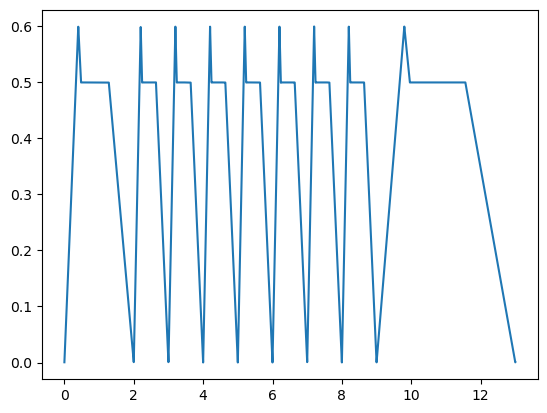

In [141]:
# Display the envelope
display_envelope(con_ADSR)

**Supplementary Questions:** Instead of enveloping with the ADSR function, how would you envelope with a decaying exponential?

Question answered at the end of document

## Task 3: Overlapping Notes

In [142]:
def overlap(notes, offset):
    """Joins notes together with overlap between consecutive notes.

    Args:
        notes: An array of notes to be joined.
        offset: The amount of allowable overlap between consecutive notes.

    Returns:
        A score made from the input notes.
    """
    overlap_samples = int(offset * DEFAULT_SAMPLE_RATE)
    final_audio = notes[0]  # Start with the first note

    for i in range(1, len(notes)):
        # Ensure the notes are long enough; pad if necessary
        if len(final_audio) < overlap_samples:
            final_audio = np.pad(final_audio, (0, overlap_samples - len(final_audio)))
        if len(notes[i]) < overlap_samples:
            # Pad with zeros if the lengths are different
            notes[i] = np.pad(notes[i], (0, overlap_samples - len(notes[i]))) 
        
        # Extract the overlap regions
        overlap_start = notes[i][:overlap_samples]
        overlap_end = final_audio[-overlap_samples:]
        
        # Create a linear ramp for blending
        ramp = np.linspace(0, 1, overlap_samples)
        blended = overlap_end * (1 - ramp) + overlap_start * ramp
        
        # Concatenate the blended region with the rest of the note
        final_audio = np.concatenate([final_audio[:-overlap_samples], blended, notes[i][overlap_samples:]])
    
    # Make sure the final audio stays within 1.0
    max_amp = np.max(np.abs(final_audio))
    if max_amp > 1.0:
        final_audio = final_audio / max_amp

    return final_audio

In [143]:
### Smooth the sound by overlapping the notes.
overlap_duration = 0.2

# Apply overlapping to notes with ADSR applied
overlapping_audio = overlap(ADSR, overlap_duration)

# Play the audio sample
play(overlapping_audio)

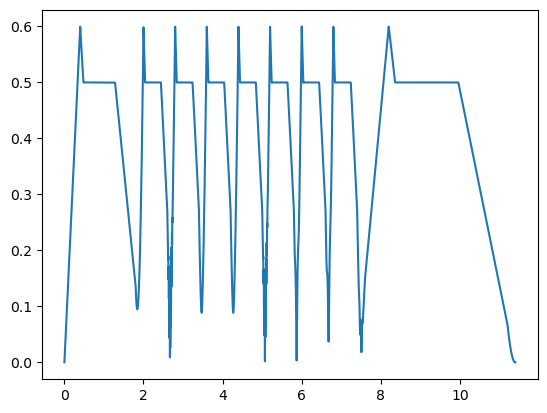

In [164]:
# Display the envelope
display_envelope(overlapping_audio)

Part 4: Extra Credit - Happy Birthday

In [161]:
#Extra Credit.
A = 220
D = A* 2**(5/12)
E = A* 2**(7/12)
G = A * 2** (10/12)
F_sharp = 220* 2 **(9/12)
F = A*2**(10/12)
C_sharp = 220*2**(4/12)
# Corrected musical notes for "Happy Birthday"
musical = [
    A, A, B, A, D, C_sharp,  # Happy birthday to you
    A, A, B, A, E, D,  # Happy birthday to you
    A, A, A, F_sharp, D, C_sharp, B,  # Happy birthday dear [Name]
    G, G, F_sharp, D, E, D  # Happy birthday to you
]

data = []

pause = np.zeros(int(0.75))*DEFAULT_SAMPLE_RATE  # 1-second pause
duration = [
    0.75, 0.25, 1, 1, 1, 2,  # Happy birthday to you
    0.75, 0.25, 1, 1, 1, 2,  # Happy birthday to you
    0.75, 0.25, 1, 1, 1, 1, 3,  # Happy birthday dear [Name]
    1, 1, 1, 1, 1, 2  # Happy birthday to you
]
for i in range(len(musical)):
    data.append(note(musical[i],duration[i]))
    
    if i != 440:
        data.append(pause)  # Add pause after each note but not behind the A (one octave higher)

concatenated_data = np.concatenate(data)*32767

# Play the audio sample
play(concatenated_data)


# Use your function Apply an ADSR envelope to each note.

ADSR = []
for i in data:
    ADSR.append(adsr(i))
Con_ADSR = np.concatenate(ADSR)
# Play the audio sample
play(Con_ADSR)



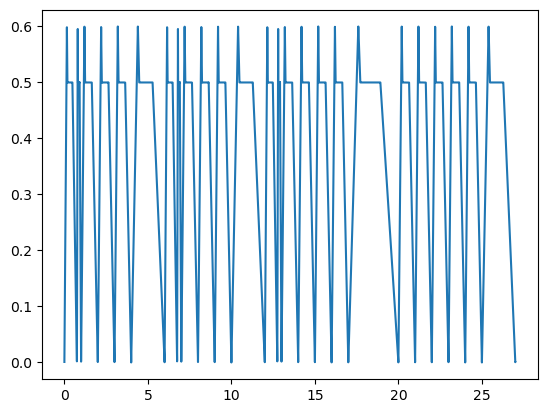

In [160]:
display_envelope(Con_ADSR)

In [162]:
# Apply overlapping to notes with ADSR applied
overlapping_audio2 = overlap(ADSR, overlap_duration)

# Play the audio sample
play(overlapping_audio2)

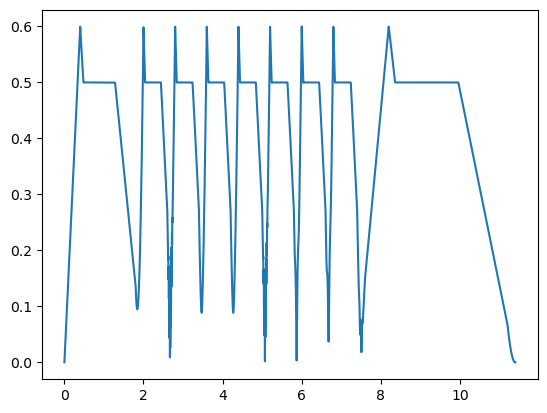

In [163]:
# Display the envelope
display_envelope(overlapping_audio)

**Supplementary Questions:** Instead of enveloping with the ADSR function, how would you envelope with a decaying exponential?


The decaying exponential envelope give the amplitude over time a continuous decay which have a smooth and fade out effect.


The decaying exponential envelope is: y(t) = A*exp(-lamba*t)


Afterward, apply y(t) on the note with multiplication.


A: Initial Amplitude (Normally just 1)
lamba: Decay rate that control how fast the amplitude decreases
t: Time, which range from starting to the end of the note


Why do we choose the birthday song?

Because my birthday is coming up! And it’ll be fun to generate it with python.